# Lesson 13.5 Xavier方法与kaiming方法（HE初始化）

在进行了一系列的理论推导和代码准备工作之后，接下来，我们介绍参数初始化优化方法，也就是针对tanh和Sigmoid激活函数的Xavier方法，以及针对ReLU激活函数的Kaiming方法（HE初始化）。当然，在经过漫长的准备工作后，实际落地应用过程并不会太过于复杂。

## 1. Xavier方法

### 1.1 Xavier初始化参数方法基础理论

回顾Glorot条件，我们要求正向传播时候流经每一层前后的方差一致，并且反向传播时候数据流经每一层，该层梯度前后方向一致。我们将前者称为向前传播条件，后者称为反向传播条件。我们先看当前向前传播条件成立时候，有如下计算过程。

首先，数据流至某一层时，该层神经元接收到的数据可以通过如下方法算得：

$$
z_j=\sum_{i=1}^n w_i x_i
$$

其中 $ z_{j} $ 表示当前某层神经元接收到的数据， $ x_{i} $ 表示上一层神经元传出的数据， $ w_{i} $ 代表连接对应两个神经元之间的权重，当然，如果我们将 $z_{j} $ , $ x_{i} $ , $ w_{i} $ 看成是随机变量，则上式就能够表示计算过程的一般情况。并且 $ w_{i} $ , $ x_{i} $ 的方差计算过程如下：

$$
\operatorname{Var}\left(w_i x_i\right)=E\left[w_i\right]^2 \operatorname{Var}\left(x_i\right)+E\left[x_i\right]^2 \operatorname{Var}\left(w_i\right)+\operatorname{Var}\left(w_i\right) \operatorname{Var}\left(x_i\right)
$$

> 上述过程涉及基础数学知识，设X为随机变量，D（x）表示X方差，E（X）表示其期望，则有：
$$
D(X)=E\left(X^2\right)-E(X)^2
$$

进一步，如果X，Y表示随机变量并且相互独立，则有：

$$
D(X Y)=E\left((X Y)^2\right)-(E(X Y))^2=E\left(X^2\right) E\left(Y^2\right)-(E(X) E(Y))^2
$$

并且对其简单变形，可以得出：

$$
\begin{aligned}
& D(X Y)=E(X)^2 D(Y)+E(Y)^2 D(X)+D(X) D(Y) \\
& =E(X)^2\left[E\left(Y^2\right)-E(Y)^2\right]+E(Y)^2\left[E\left(X^2\right)-E(X)^2\right]+\left[E\left(X^2\right)-E(X)^2\right]\left[E\left(Y^2\right)-E(Y)^2\right] \\
& =E(X)^2 E\left(Y^2\right)-E(X)^2 E(Y)^2+E(Y)^2 E\left(X^2\right)-E(Y)^2 E(X)^2+E\left(X^2\right) E\left(Y^2\right)-E(X)^2 E\left(Y^2\right)-E\left(X^2\right) E(Y)^2
& +E(X)^2 E(Y)^2 \\
& =E\left(X^2\right) E\left(Y^2\right)-E(X)^2 E(Y)^2 \\
&
\end{aligned}
$$

其中，Var()表示方差计算，E()表示均值计算。由于我们假设参数是以0为均值的均匀分布或者0为均值的正态分布，因此E（wi）= 0,而此前我们介绍，假设输入数据是Zero-Centered的，因此E（xi）= 0，所以上一式可以进一步简化为：

$$
\operatorname{Var}\left(w_i x_i\right)=\operatorname{Var}\left(w_i\right) \operatorname{Var}\left(x_i\right)
$$

而对于z来说，$z=\sum_{i=1}^n w_i x_i$ ,其方差计算过程如下：

$$
\operatorname{Var}(z)=\sum_{i=1}^n \operatorname{Var}\left(w_i x_i\right)=\sum_{i=1}^n \operatorname{Var}\left(w_i\right) \operatorname{Var}\left(x_i\right)
$$

此处补充数学过程，

$$
D(X+Y)=D(X)+D(Y)+\operatorname{COV}(X, Y)
$$

其中 $ COV(X, Y)$ 是二者的协方差，当X, Y相互独立时，$ COV(X, Y) = 0 $

此时，我们可以认为X 和 W 是独立同分布的（一个是采集处理后的数据，一个是随机生成的参数），因此每个Var(wi)Var(xi)也是独立同分布的，因此所有的wi都可以用一个随机变量wi 表示，所有的xi也可以用一个随机变量x表示，上式可进一步简写为：

$$
\operatorname{Var}(z)=\sum_{i=1}^n \operatorname{Var}\left(w_i\right) \operatorname{Var}\left(x_i\right)=n \operatorname{Var}(w) \operatorname{Var}(x)
$$

而我们希望线性变换不影响数据方差，因此有：

$$
\operatorname{Var}(z)=\operatorname{Var}(x)
$$

进一步可以得：

$$
\operatorname{Var}(w)=\frac{1}{n}
$$

其中，n是上一层神经元的个数。需要注意的是，上式只考虑了正向传播的情况，而实际在进行反向传播时候，上述过程正好相反。反向传播时z代表上一层神经元接收到的数据，而X则代表当前层传出的数据，虽然计算公式不变，但n的含义却发生了变化。为了进行区分，我们将正向传播时的n,也就是代表上一层神经元个数的变量，命名为 $ n_{in} $ ，而在进行反向传播时的n，也就是代表当前层神经元个数的变量，命名为 $ n_{out} $。为了同时兼顾向前传播和反向传播这两种情况，我们将w的最终方差取值为：

$$
\operatorname{Var}(w)=\frac{1}{\frac{n_{\text {int }}+n_{\text {out }}}{2}}=\frac{2}{n_{\text {in }}+n_{\text {out }}}
$$

> 取为均值，也就是折中的方案

而此时，如果我们设置w服从均匀在[-a, a]区间内均匀分布，则w的方差为：

$$
\operatorname{Var}(w)=\frac{(a+a)^2}{12}=\frac{4 a^2}{12}=\frac{a^2}{3}=\frac{2}{n_{\text {in }}+n_{\text {out }}}
$$

> 注：服从在[a, b]区间上均匀分布的随机变量方差为 $\frac{(b-a)^2}{12}$

进而可得：

$$
a=\sqrt{\frac{6}{n_{\text {in }}+n_{\text {out }}}}
$$

即 $ w $ 是均匀分布在 $\left(-\sqrt{\frac{6}{n_{\text {int }}+n_{\text {out }}}} , \sqrt{\frac{6}{n_{\text {in }}+n_{\text {out }}}}\right)$ 上的随机变量。

当然，如果我们假设w是服从正态分布的，则 w服从 $\left(0, \sqrt{\frac{2}{n_{\text {int }}+n_{\text {out }}}}\right)$ 的随机变量。据此，我们就能设置每一层的初始参数了。当然，在PyTorch中，可以使用init方法来进行初始化。

> 另外，一种更加严谨的，指代某一次传播过程上一层神经元数量和下一层神经元数量的叫法是扇入（fan in）和扇出（fan out），由此Xavier方法中初始参数的方差也可以写为： $\operatorname{Var}(w)=\frac{2}{\text { fan }_{\text {int }} + \text { fan }_{\text {out } }}$, 另外，Xavier在论文中指出，应该保持各层的激活值和梯度的方差在传播过程中保持一致，也被称为Glorot条件。

> 对于参数初始化计算过程，最重要的是确定参数的方差，如果是正态分布，由于均值是0，因此可以快速确定其分布，而如果是均匀分布，则可通过 bound $=\sqrt{3 v a r}$ 来确定分布区间[-bound, bound]。而在Xavier初始化方法中， var $=\frac{1}{\text {fan}_{avg}}$，其中： 
> $$
fan_{avg}=\frac{{fan_{in}+ fan_{{out }}}}{2}
$$

> 最关键的，我们需要知道，对于创建 随机分布的初始参数来说，只要确定其方差，就能确定其均匀分布或者正态分布形式。

## 2. Xavier初始化参数执行方法

### 2.1 PyTorch实现Xavier均匀分布的参数创建

我们可以使用 torch.nn.init.xavier_uniform_进行初始化参数设置。

In [711]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchLearning import *

from torch.utils.tensorboard import SummaryWriter

# 一个cell输出多个结果
writer = SummaryWriter(log_dir= 'reg_loss')


In [712]:
nn.init.xavier_uniform_?

Signature: nn.init.xavier_uniform_(tensor: torch.Tensor, gain: float = 1.0) -> torch.Tensor
Docstring:
Fills the input `Tensor` with values according to the method
described in `Understanding the difficulty of training deep feedforward
neural networks` - Glorot, X. & Bengio, Y. (2010), using a uniform
distribution. The resulting tensor will have values sampled from
:math:`\mathcal{U}(-a, a)` where

.. math::
    a = \text{gain} \times \sqrt{\frac{6}{\text{fan\_in} + \text{fan\_out}}}

Also known as Glorot initialization.

Args:
    tensor: an n-dimensional `torch.Tensor`
    gain: an optional scaling factor

Examples:
    >>> w = torch.empty(3, 5)
    >>> nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))
File:      e:\anaconda\envs\machinelearning\lib\site-packages\torch\nn\init.py
Type:      function

当然，这里需要注意的是，函数处理的对象是张量，也就是说只要输入张量，就可以自动进行处理。期中 $ fan_{in} $ 由张量的列决定， $ fan_{out} $ 由张量的行数决定。

从这里我们可以看到，此时均匀分布的边界为

$$
a=\text { gain } \times \sqrt{\frac{6}{\text { fan } _ {in }+ \text { fan }_{out}}}
$$

其中gain为增益系数，用于手动调整均匀分布的边界，暂时不建议调整。

In [713]:
t = torch.arange(8).reshape(2, 4).float()
t

tensor([[0., 1., 2., 3.],
        [4., 5., 6., 7.]])

In [714]:
nn.init.xavier_uniform_(t)

tensor([[-0.8388,  0.0399,  0.9365,  0.4066],
        [-0.3710, -0.0406,  0.4493, -0.0756]])

* Sigmoid激活函数

接下来，在建模过程中使用Xavier初始化方法测试效果，首先是数据准备与核心参数定义。

In [715]:
# 设置随机数种子
torch.manual_seed(420)

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w = [2, -1], bias= False, deg= 2)

# 进行数据集的切分与加载
train_loader, test_loader = split_loader(features, labels)

# 初始化核心参数
lr = 0.03
num_epochs = 20



然后实例化模型，调整模型初始参数，以及创建用于对比模型效果的模型容器，首先我们先创建一组相对简单的模型，也就是包含三个Sigmoid隐藏层的神经网络模型，对比初始化效果

In [748]:
# 设置随机数种子
torch.manual_seed(420)

# 实例化模型
sigmoid_model3 = Sigmoid_class3()        # 保留原参数
sigmoid_model3_init = Sigmoid_class3()      # 使用Xavier初始化参数

# 修改init模型初始参数
for m in sigmoid_model3_init.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

# 创建模型容器
model_1 = [ sigmoid_model3_init, sigmoid_model3]
name_1 = ['sigmoid_model3_init', 'sigmoid_model3']


In [749]:
train_1, test_1 = model_comparison(model_1= model_1,
                                   name_1= name_1,
                                   train_data= train_loader,
                                   test_data= test_loader,
                                   num_epochs= 2, 
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr = lr,
                                   cla= False,
                                   eva= mse_cal)

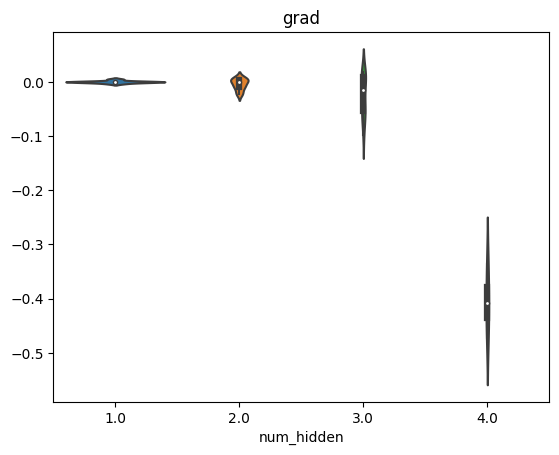

In [750]:
weights_vp(sigmoid_model3, att= 'grad')

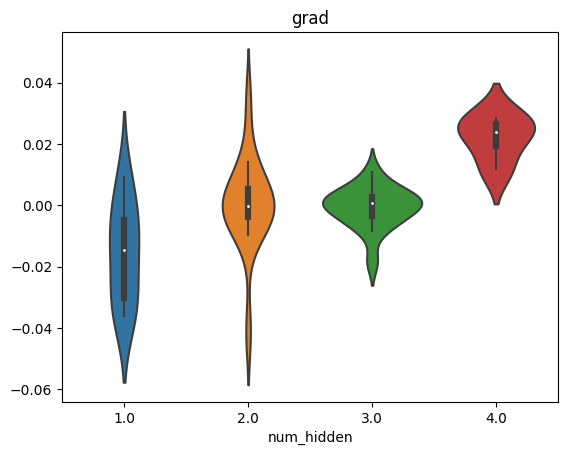

In [751]:
weights_vp(sigmoid_model3_init, att= 'grad')

我们发现，在num_epochs取值为2的时候（只迭代了一轮），经过Xavier初始化的模型梯度整体更加稳定，并且没有出现梯度消失的情况，反观原始模型sigmoid_model2，第一层的梯度已经非常小了，已经出现了梯度消失的倾向。而我们知道，各层梯度的情况就代表着模型学习的状态，很明显经过初始化的模型各层都处于平稳学习状态，此时模型收敛速度较快。我们也可以通过MSE曲线进行验证。

In [752]:
train_1, test_1 = model_comparison(model_1= model_1,
                                   name_1= name_1,
                                   train_data= train_loader,
                                   test_data= test_loader,
                                   num_epochs= num_epochs,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr= lr,
                                   cla= False,
                                   eva= mse_cal)

Text(0.5, 1.0, 'mse_train')

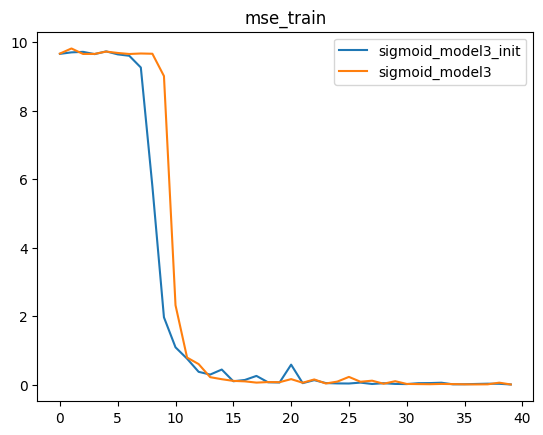

In [753]:
# 训练误差
for i, name in enumerate(name_1):
    plt.plot(list(range(num_epochs)), train_1[i], label = name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_test')

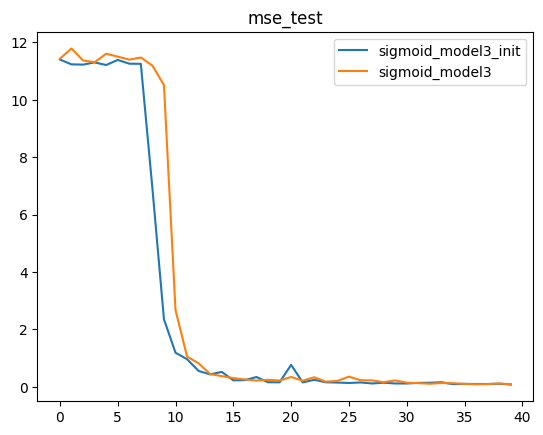

In [754]:
# 测试误差
for i, name in enumerate(name_1):
    plt.plot(list(range(num_epochs)), test_1[i], label = name)
plt.legend(loc = 1)
plt.title('mse_test')

由此我们可知，Xavier初始化的作用核心在于保证各层梯度取值的平稳分布，从而确保各层模型学习的有效性，最终在模型结果的表现上，经过Xavier初始化参数的模型学习效率更高，收敛速度更快。上述结果也验证了Xavier初始化的有效性。

当然，在一些极端情况下，Xavier初始化效果会更加明显。我们以四层Sigmoid隐藏层的神经网络为例，观察Xavier初始化在规避梯度消失问题时的效果。

In [739]:
# 设置随机数种子
torch.manual_seed(24)

# 实例化模型
sigmoid_model4 = Sigmoid_class4()        # 保留原参数
sigmoid_model4_init = Sigmoid_class4()      # 使用Xavier初始化参数

# 修改init模型初始参数
for m in sigmoid_model4_init.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

# 创建模型容器
model_1 = [ sigmoid_model4, sigmoid_model4_init]
name_1 = ['sigmoid_model4', 'sigmoid_model4_init']

# 核心参数
lr = 0.03
num_epochs = 40

# 模型训练

train_1, test_1 = model_comparison(model_1= model_1,
                                   name_1= name_1,
                                   train_data= train_loader,
                                   test_data= test_loader,
                                   num_epochs= num_epochs,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr= lr,
                                   cla= False,
                                   eva= mse_cal)

Text(0.5, 1.0, 'mse_train')

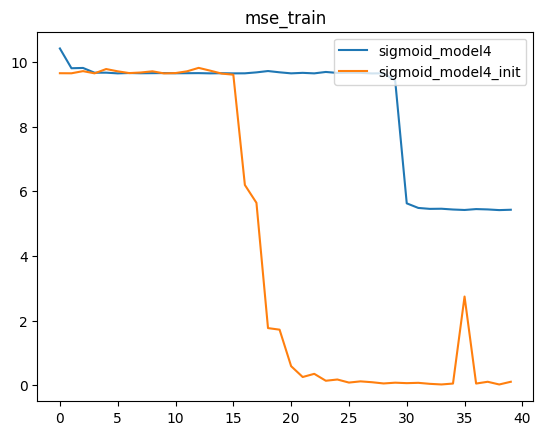

In [740]:
# 训练误差
for i, name in enumerate(name_1):
    plt.plot(list(range(num_epochs)), train_1[i], label = name)
plt.legend(loc = 1)
plt.title('mse_train')

sigmoid_model4是Lesson 13.2 中出现严重梯度消失的模型，由于前几层基本丧失学习能力，sigmoid_model4本身效果并不好。但加入Xavier初始化之后，我们发现，init模型能够极大程度规避梯度消失问题，从而获得更好的效果。

不过正如此前所说，相比于sigmoid激活函数，Xavier初始化方法更适合于tanh激活函数，核心原因在于tanh激活函数本身能够生成Zero-centered Data,配合Xavier初始化生成的参数，能够更好的确保各层梯度平稳，确保各层平稳学习。

* tanh激活函数

我们以三层tanh激活函数隐藏层的神经网络为例，测试Xavier初始化效果。

In [773]:
# 设置随机数种子
torch.manual_seed(420)

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w = [2, -1], bias= False, deg=2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)

In [774]:
# 设置随机数种子
torch.manual_seed(420)

# 实例化模型
tanh_model3 = tanh_class3()     # 保留原参数
tanh_model3_init = tanh_class3()    # 使用Xavier初始化参数

In [775]:
# 设置随机数种子
torch.manual_seed(420)

# 修改init模型初始参数
for m in tanh_model3_init.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

# 创建模型容器
model_1 = [tanh_model3, tanh_model3_init]
name_1 = ['tanh_model3', 'tanh_model3_init']

# 核心参数
lr = 0.03
num_epochs = 20

In [776]:
# 模型训练
train_1, test_1 = model_comparison(model_1 = model_1,
                                   name_1= name_1,
                                   train_data= train_loader,
                                   test_data= test_loader,
                                   num_epochs= 2,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr = lr,
                                   cla = False,
                                   eva= mse_cal)

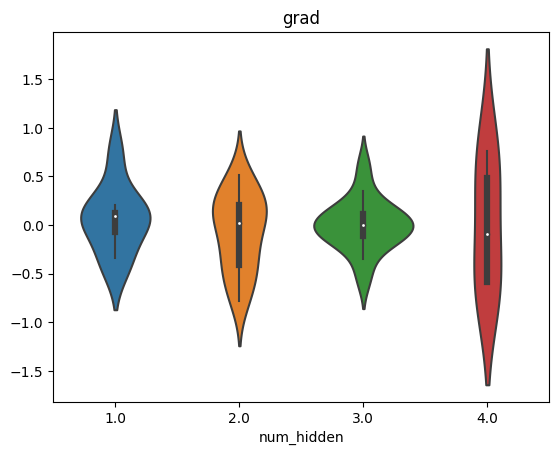

In [777]:
weights_vp(tanh_model3, att= 'grad')

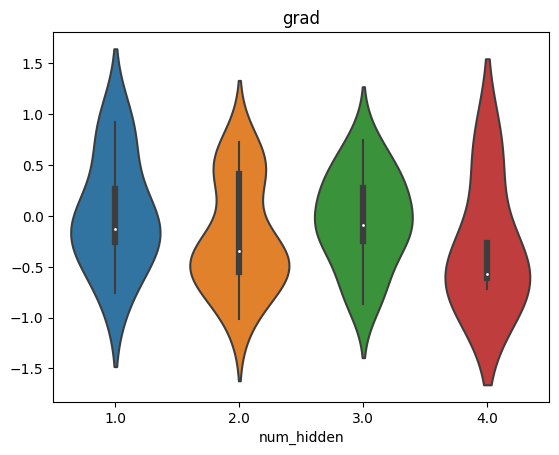

In [778]:
weights_vp(tanh_model3_init, att= 'grad')

同样，能够看出经过Xavier参数初始化后的模型梯度更加平稳，进而我们判断，经过初始化之后的模型初始迭代时收敛速度更快

In [784]:
# 设置随机数种子
torch.manual_seed(420)

# 实例化模型
tanh_model3 = tanh_class3()     # 保留原参数
tanh_model3_init = tanh_class3()    # 使用Xavier初始化参数

# 修改init模型初始参数
for m in tanh_model3_init.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

# 创建模型容器
model_1 = [tanh_model3, tanh_model3_init]
name_1 = ['tanh_model3', 'tanh_model3_init']

# 核心参数
lr = 0.03
num_epochs = 40

# 模型训练
train_1, test_1 = model_comparison(model_1 = model_1,
                                   name_1= name_1,
                                   train_data= train_loader,
                                   test_data= test_loader,
                                   num_epochs= num_epochs,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr = lr,
                                   cla = False,
                                   eva= mse_cal)

Text(0.5, 1.0, 'mse_train')

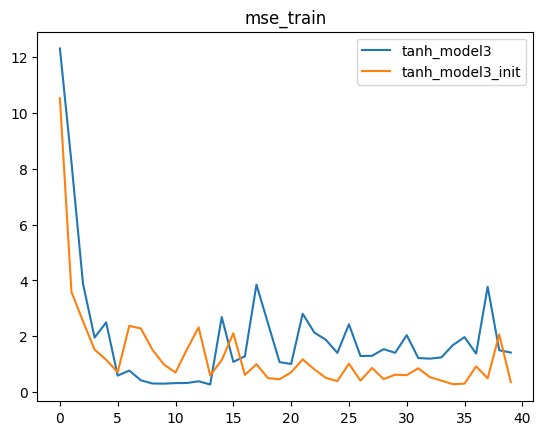

In [785]:
# 训练误差
for i, name in enumerate(name_1):
    plt.plot(list(range(num_epochs)), train_1[i], label = name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_train')

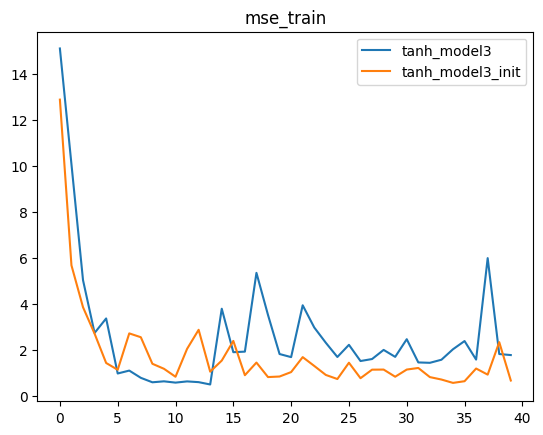

In [786]:
# 测试误差
for i, name in enumerate(name_1):
    plt.plot(list(range(num_epochs)), test_1[i], label = name)
plt.legend(loc = 1)
plt.title('mse_train')

同样我们能够发现，模型收敛速度更快，迭代多轮之后也变得更加稳定。

### 2.2 PyTorch 实现Xavier高斯分布的参数创建

类似的，我们可以使用 torch.nn.init.xavier_normal_进行参数初始化设置。

In [787]:
torch.nn.init.xavier_normal_?

Signature: torch.nn.init.xavier_normal_(tensor: torch.Tensor, gain: float = 1.0) -> torch.Tensor
Docstring:
Fills the input `Tensor` with values according to the method
described in `Understanding the difficulty of training deep feedforward
neural networks` - Glorot, X. & Bengio, Y. (2010), using a normal
distribution. The resulting tensor will have values sampled from
:math:`\mathcal{N}(0, \text{std}^2)` where

.. math::
    \text{std} = \text{gain} \times \sqrt{\frac{2}{\text{fan\_in} + \text{fan\_out}}}

Also known as Glorot initialization.

Args:
    tensor: an n-dimensional `torch.Tensor`
    gain: an optional scaling factor

Examples:
    >>> w = torch.empty(3, 5)
    >>> nn.init.xavier_normal_(w)
File:      e:\anaconda\envs\machinelearning\lib\site-packages\torch\nn\init.py
Type:      function

$$    \text{std} = \text{gain} \times \sqrt{\frac{2}{\text{fan\_in} + \text{fan\_out}}}
$$

当然，修改参数的方法也是相同的，例如：

In [788]:
# 实例化模型
sigmoid_model2 = Sigmoid_class2()

# 修改init模型初始参数
for m in sigmoid_model2.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)

其它测试初始化效果的相关实验和此前操作流程一致，同学们可以自行尝试。从理论上来说，均匀分布和高斯分布并没有根本区别，二者任选其一使用即可。不过也有一些不是很严谨的实验证明了均匀分布比高斯分布能够产生相对较大的梯度，因而模型学习效果会更好。

## 3. Kaiming方法（HE初始化）

### 3.1 HE初始化基本理论

尽管Xavier初始化能够在Sigmoid和tanh激活函数叠加的神经网络中起到一定的效果，但由于ReLU激活函数属于非饱和类激活函数，并不会出现类似Sigmoid和tanh激活函数使用过程中可能存在的梯度消失或者梯度爆炸问题，反而因为ReLU激活函数的不饱和特性，ReLU激活函数的叠加极有可能出现神经元活性消失的问题，很明显，该类问题无法通过Xavier初始化解决。

尽管如此，对参数的初始值进行合理设置，仍然是保证模型有效性的有效方法，同样也能在一定程度上解决ReLU激活函数的神经元活性消失问题。目前通用的针对ReLU激活函数的初始化参数方法，是由何凯明在2015年的《Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification》一文所提出的HE初始化方法，也被称为Kaiming方法。

> 近一轮深度学习的兴起也就在10年间，我们接触到的很多算法和优化方法基本都是发表于10年内的。

当然，HE初始化也遵循Glorot条件，即参数初始化结果要求正向传播时各层接收到的数据方差保持一致，反向传播时各层参数梯度的方差也保持一致，不过由于每一层的激活值（激活函数输出结果）均值不为0，因此Xavier的数学推导过程不再成立。关于HE初始化的数学推导此处不进行深入讲解，感兴趣的同学可以自行参考论文中给出的推导过程。需要知道的是，经过一系列的推导和论证之后，HE初始化仍然是规定参数是满足均值为0的随机变量，并且仍然借助均匀分布和高斯分布进行随机变量创建，不同的是Xavier中参数方差为：

$$
\operatorname{Var}(w)_{X \text { avier }}=\frac{2}{f a n_{\text {in }}+f a n_{\text {out }}}
$$


而HE初始化过程中，参数方差为：

$$
\operatorname{Var}(w)_{H E}=\frac{2}{\operatorname{fan}_{\text {in }}} \text { 或 } \operatorname{Var}(w)_{H E}=\frac{2}{\operatorname{fan}_{\text {out }}}
$$

也就是分子不变，分母取某层扇入或者扇出的神经元的数量，同时论文中给出论证二者没有明显区别，建模过程任选其一即可。

当然，根据参数方差，我们就能确定参数满足均匀分布时的边界，以及满足高斯分布时的基本形态。均匀分布时$bound = \sqrt{(3var)} $, 因此参数分布区间为：

$$
\left(-\sqrt{\frac{6}{f a n_{i n}}}, \sqrt{\frac{6}{f^2 n_{i n}}}\right)
$$

> 值得注意的是，HE初始化不仅针对ReLU激活函数，还可以对其变种激活函数使用。

> 后续还将介绍其它初始化方法，我们仍然可以从以下几个角度进行理解：
> 
> （1）为了满足或者更好满足Glorot条件
> 
> （2）数学理论推导出参数方差
> 
> （3）方差由扇如和扇出神经元个数组成

### 3.2 HE初始化在PyTorch中实现

#### 3.2.1 PyTorch实现HE初始化的均匀分布参数创建

我们可以使用torch.nn.init.kaiming_uniform_进行初始化参数设置。

In [789]:
nn.init.kaiming_uniform_?

Signature:
nn.init.kaiming_uniform_(
    tensor: torch.Tensor,
    a: float = 0,
    mode: str = 'fan_in',
    nonlinearity: str = 'leaky_relu',
)
Docstring:
Fills the input `Tensor` with values according to the method
described in `Delving deep into rectifiers: Surpassing human-level
performance on ImageNet classification` - He, K. et al. (2015), using a
uniform distribution. The resulting tensor will have values sampled from
:math:`\mathcal{U}(-\text{bound}, \text{bound})` where

.. math::
    \text{bound} = \text{gain} \times \sqrt{\frac{3}{\text{fan\_mode}}}

Also known as He initialization.

Args:
    tensor: an n-dimensional `torch.Tensor`
    a: the negative slope of the rectifier used after this layer (only
        used with ``'leaky_relu'``)
    mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
        preserves the magnitude of the variance of the weights in the
        forward pass. Choosing ``'fan_out'`` preserves the magnitudes in the
        back

相关参数解释：

* mode: 参数表示选择带入扇入还是扇出的神经元个数进行计算，正如前文所说，理论上二者对建模并没有明显影响，可任选其一，但实际由于模型个体差异，在实际使用过程中还是略有差异，我们可以根据实际效果进行选择；
* a：为使用ReLU变种激活函数时的修正系数；
* nonlinearity：表示所选用的变种ReLU激活函数类型，需要配合a参数使用，相关使用方法我们将在后续介绍ReLU变种激活函数的使用时一并介绍。

另外，值得注意的是，kaiming方法的帮助文档中的数学公式有误，切勿参考此公式进行建模。

帮助文档中公式

$$    \text{bound} = \text{gain} \times \sqrt{\frac{3}{\text{fan\_mode}}}
$$


而实际上kaiming方法并没有gain增益系数，只有a一个修正系数，实际公式如下：

$$
\text { bound }=\sqrt{\left.\frac{6}{\left(1+a^2\right) f a n_{i n}}\right)}
$$

和Xavier方法一样，kaiming方法直接对张量的值进行修改，并且张量列数表示$ fan_{in} $的个数，行数表示$ fan_{out} $的个数，据此，我们简单测试下公式正确性：

In [790]:
t = torch.arange(12).reshape(2, 6).float()
t

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.],
        [ 6.,  7.,  8.,  9., 10., 11.]])

In [791]:
# 设置随机数种子
torch.manual_seed(420)
torch.nn.init.kaiming_uniform_(t)   # 此时扇入个数是6

tensor([[ 0.6107, -0.6019,  0.9517, -0.7944, -0.3051, -0.6891],
        [ 0.7712,  0.3751, -0.4988, -0.7734, -0.5790, -0.1929]])

In [792]:
# 设置随机数种子
torch.manual_seed(420)
torch.nn.init.kaiming_uniform_(t, a= 1)     #此时分母是12

tensor([[ 0.4318, -0.4256,  0.6730, -0.5617, -0.2157, -0.4873],
        [ 0.5453,  0.2653, -0.3527, -0.5469, -0.4094, -0.1364]])

据此，验证了公式的正确性。接下来，尝试在建模过程中使用kaiming方法，验证是否能够加快迭代效率，并且规避神经元活性失效问题。

> HE初始化如何帮助模型规避Dead_ReLU Problem？其核心在于模型初始化时如果参数完全随机选择，就有可能出现初始参数全部输出0的结果，而通过HE初始化的参数不会出现上述情况。

In [794]:
# 设置随机数种子
torch.manual_seed(420)

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w = [2, 1], bias= False, deg= 2)

# 进行数据集切分与加载
train_loader, test_loader = split_loader(features, labels)

# 初始化核心参数
lr = 0.001
num_epochs = 20

In [795]:
# 设置随机种子
torch.manual_seed(420)

# 实例化模型
relu_model3 = Relu_class3()     # 保留原参数
relu_model3_init = Relu_class3()    # 使用HE初始化参数

# 修改init模型初始参数
for m in relu_model3_init.modules():
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)

# 创建模型容器
model_1 = [relu_model3, relu_model3_init]
name_1 = ['relu_model3', 'relu_model3_init']

In [796]:
# 模型训练
train_1, test_1 = model_comparison(model_1 = model_1,
                                   name_1= name_1,
                                   train_data= train_loader,
                                   test_data= test_loader,
                                   num_epochs= num_epochs,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr = lr,
                                   cla = False,
                                   eva= mse_cal)

Text(0.5, 1.0, 'mse_train')

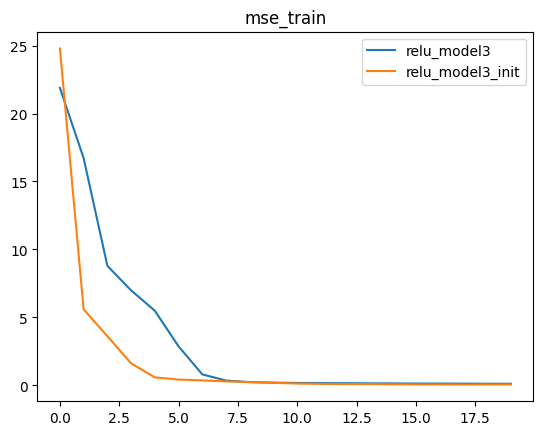

In [797]:
# 训练误差
for i, name in enumerate(name_1):
    plt.plot(list(range(num_epochs)), train_1[i], label = name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_train')

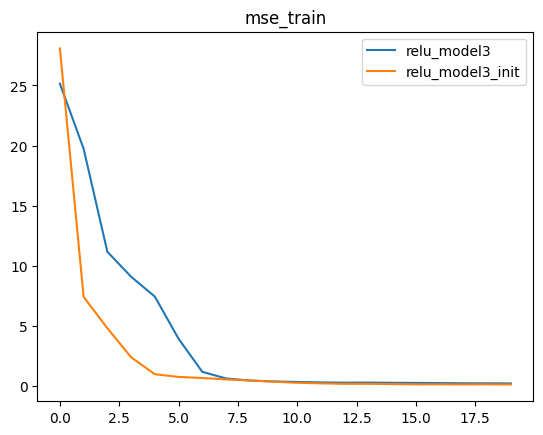

In [798]:
# 测试误差
for i, name in enumerate(name_1):
    plt.plot(list(range(num_epochs)), test_1[i], label = name)
plt.legend(loc = 1)
plt.title('mse_train')

我们发现，使用HE初始化之后模型收敛速度明显提升。

#### 3.2.2 PyTorch实现HE初始化的正态分布参数创建

类似的，我们可以使用torch.nn.init.kaiming_normal_来进行满足正态分布的初始化参数设置。

In [799]:
nn.init.kaiming_normal_?

Signature:
nn.init.kaiming_normal_(
    tensor: torch.Tensor,
    a: float = 0,
    mode: str = 'fan_in',
    nonlinearity: str = 'leaky_relu',
)
Docstring:
Fills the input `Tensor` with values according to the method
described in `Delving deep into rectifiers: Surpassing human-level
performance on ImageNet classification` - He, K. et al. (2015), using a
normal distribution. The resulting tensor will have values sampled from
:math:`\mathcal{N}(0, \text{std}^2)` where

.. math::
    \text{std} = \frac{\text{gain}}{\sqrt{\text{fan\_mode}}}

Also known as He initialization.

Args:
    tensor: an n-dimensional `torch.Tensor`
    a: the negative slope of the rectifier used after this layer (only
        used with ``'leaky_relu'``)
    mode: either ``'fan_in'`` (default) or ``'fan_out'``. Choosing ``'fan_in'``
        preserves the magnitude of the variance of the weights in the
        forward pass. Choosing ``'fan_out'`` preserves the magnitudes in the
        backwards pass.
    nonlinear

同样，说明文档中的公式存在错误。以下是说明文档中的公式：

$$    \text{std} = \frac{\text{gain}}{\sqrt{\text{fan\_mode}}}
$$

实际上，PyTorch中所使用的HE初始化时，初始参数的方差为：

$$
\operatorname{Var}(w)=\frac{2}{\left(1+a^2\right) f a n_{i n}}
$$

其中，a为ReLU变种激活函数的修正系数，需要配合ReLU变种激活函数共同使用，扇入神经元个数和扇出神经元个数等效，并且

$$
s t d(w)=\sqrt{\frac{2}{\left(1+a^2\right) f a n_{i n}}}
$$

接下来，简单实践测试效果：

In [800]:
# 设置随机种子
torch.manual_seed(420)

# 实例化模型
relu_model3 = Relu_class3()     # 保留原参数
relu_model3_init = Relu_class3()    # 使用HE初始化参数

# 修改init模型初始参数
for m in relu_model3_init.modules():
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)

# 创建模型容器
model_1 = [relu_model3, relu_model3_init]
name_1 = ['relu_model3', 'relu_model3_init']

In [801]:
# 模型训练
train_1, test_1 = model_comparison(model_1 = model_1,
                                   name_1= name_1,
                                   train_data= train_loader,
                                   test_data= test_loader,
                                   num_epochs= num_epochs,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr = lr,
                                   cla = False,
                                   eva= mse_cal)

Text(0.5, 1.0, 'mse_train')

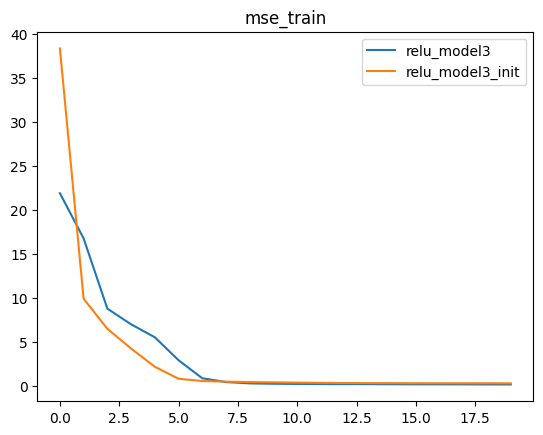

In [802]:
# 训练误差
for i, name in enumerate(name_1):
    plt.plot(list(range(num_epochs)), train_1[i], label = name)
plt.legend(loc = 1)
plt.title('mse_train')

Text(0.5, 1.0, 'mse_train')

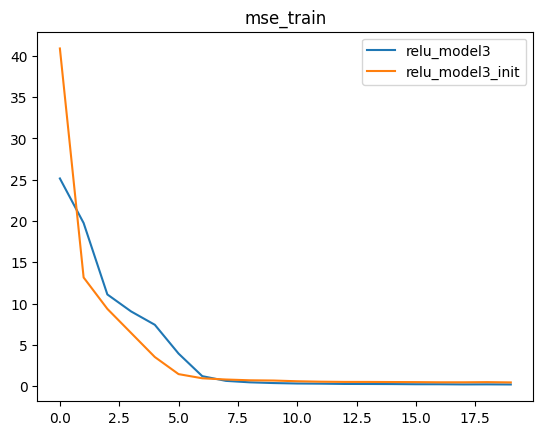

In [803]:
# 测试误差
for i, name in enumerate(name_1):
    plt.plot(list(range(num_epochs)), test_1[i], label = name)
plt.legend(loc = 1)
plt.title('mse_train')

同样，经过HE初始化后的参数，模型收敛速度更快，也证明了HE初始化的有效性。

## 4. 参数初始化的作用局限

截止目前，我们讨论了围绕Glorot条件进行的参数初始化方法，当然，合理的设置初始参数值能够在一定程度上使得模型各层都能得到有效的学习，模型训练过程更加平稳，收敛速度更加快。但由于我们设置的是初始条件，伴随着模型不断训练，由于受到激活函数本身特性的影响，仍然有可能在迭代过程中出现梯度不均匀的现象。

然而模型一旦开始训练，我们是不能手动参与修改模型参数的。那此时应该如何处理梯度不均衡的问题呢？我们知道，影响梯度的三个核心因素，分别是参数状态值，激活值，和输入数据，参数状态值由模型迭代的数学过程决定，激活值很大程度上由我们所选取的激活函数决定，如果从Glorto条件入手，我们就只剩下一个可以人工修改的选项，每一个线性层接收到的数据。